In [2]:
import cudaq
import numpy as np
from math import floor
import auxiliary_files.labs_utils as utils

In [3]:
# try cudaq.SpinOp + Heterogeneous 
# os.environ['CUDAQ_MEMORY_POOL'] = '1' # !! check if you need
# os.environ['CUDAQ_PRECISION'] = 'single' # !! check if you need

In [4]:
#TODO - Write code to perform MTS
import numpy as np
import time
import matplotlib.pyplot as plt
import itertools

# 1) LABS objective for ±1 sequences

def pm1_to_bits01(s_pm1: np.ndarray) -> np.ndarray:
    return ((s_pm1 + 1) // 2).astype(np.int8)

def bits01_to_pm1(bits01) -> np.ndarray:
    x = np.array(bits01, dtype=np.int8)
    return (2*x - 1).astype(np.int8)  # 0->-1, 1->+1

def labs_correlations_pm1(s: np.ndarray) -> np.ndarray:
    """C[k-1] = C_k for k=1..N-1, C_k = sum_i s[i]*s[i+k]."""
    N = s.size
    C = np.empty(N-1, dtype=np.int32)
    for k in range(1, N):
        C[k-1] = int(np.dot(s[:-k], s[k:]))
    return C

def labs_energy_from_C(C: np.ndarray) -> int:
    C64 = C.astype(np.int64)
    return int(np.sum(C64*C64))

def labs_energy_pm1(s: np.ndarray) -> int:
    return labs_energy_from_C(labs_correlations_pm1(s))

def aperiodic_autocorr_full(s_pm1: np.ndarray) -> np.ndarray:
    """lags = -(N-1)..+(N-1)"""
    N = len(s_pm1)
    out = []
    for lag in range(-(N-1), N):
        if lag < 0:
            out.append(int(np.dot(s_pm1[-lag:], s_pm1[:N+lag])))
        elif lag == 0:
            out.append(int(np.dot(s_pm1, s_pm1)))
        else:
            out.append(int(np.dot(s_pm1[:-lag], s_pm1[lag:])))
    return np.array(out, dtype=int)


# 2) Algorithm 3: Combine & Mutate 


def combine_alg3(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    N = p1.size
    k = int(rng.integers(1, N))  # k in {1,...,N-1}
    child = np.empty_like(p1)
    child[:k] = p1[:k]
    child[k:] = p2[k:]
    return child

def mutate_alg3(s: np.ndarray, p_mut: float, rng: np.random.Generator) -> np.ndarray:
    out = s.copy()
    if p_mut <= 0.0:
        return out
    mask = rng.random(out.size) < p_mut
    out[mask] *= -1
    return out

# 3) Tabu Search (single-bit flip neighborhood)
#    - aspiration: allow tabu move if it improves best found in this tabu run
#    - candidate_size: evaluate subset of flips each step (CPU-friendly)


def delta_energy_single_flip_pm1(s: np.ndarray, C: np.ndarray, E: int, j: int):
    """
    After flipping s[j], update correlations deltaC and energy E_new.
    Flip affects C_k terms that involve index j:
      (j, j+k) and (j-k, j) when in bounds.
    Each affected product changes sign => delta contribution = -2*old_term.
    """
    N = s.size
    sj = int(s[j])
    deltaC = np.zeros_like(C, dtype=np.int32)

    for k in range(1, N):
        d = 0
        jp = j + k
        jm = j - k
        if jp < N:
            d += sj * int(s[jp])
        if jm >= 0:
            d += int(s[jm]) * sj
        if d != 0:
            deltaC[k-1] = -2 * d

    C64 = C.astype(np.int64)
    d64 = deltaC.astype(np.int64)
    dE = int(np.sum(2*C64*d64 + d64*d64))
    return E + dE, deltaC

def tabu_search_pm1(
    s0: np.ndarray,
    max_iters: int = 1000,
    tabu_tenure: int = 30,
    candidate_size: int = 64,
    rng: np.random.Generator | None = None,
):
    if rng is None:
        rng = np.random.default_rng()

    s = s0.copy()
    C = labs_correlations_pm1(s)
    E = labs_energy_from_C(C)

    best_s = s.copy()
    best_E = int(E)

    N = s.size
    tabu_until = np.zeros(N, dtype=np.int32)

    for it in range(1, max_iters + 1):
        # choose candidate flip indices
        if candidate_size >= N:
            candidates = np.arange(N)
        else:
            candidates = rng.choice(N, size=candidate_size, replace=False)

        chosen_j = None
        chosen_E = None
        chosen_dC = None

        # pick best admissible (tabu allowed only if aspiration)
        for j in candidates:
            E_new, dC = delta_energy_single_flip_pm1(s, C, E, int(j))
            is_tabu = tabu_until[j] > it
            if is_tabu and (E_new >= best_E):
                continue
            if (chosen_E is None) or (E_new < chosen_E):
                chosen_j, chosen_E, chosen_dC = int(j), int(E_new), dC

        # if all were blocked, ignore tabu
        if chosen_j is None:
            for j in candidates:
                E_new, dC = delta_energy_single_flip_pm1(s, C, E, int(j))
                if (chosen_E is None) or (E_new < chosen_E):
                    chosen_j, chosen_E, chosen_dC = int(j), int(E_new), dC

        # apply flip
        s[chosen_j] *= -1
        C += chosen_dC
        E = chosen_E

        # update tabu tenure (with slight randomness)
        tenure = tabu_tenure + int(rng.integers(0, max(1, tabu_tenure // 3)))
        tabu_until[chosen_j] = it + tenure

        if E < best_E:
            best_E = int(E)
            best_s = s.copy()

    return best_s, best_E




In [5]:
from cudaq import spin

cudaq.set_target("nvidia")

# 1. define LABS Hamiltonian
# def get_labs_hamiltonian(N: int):
#     """
#     H = sum_{k=1}^{N-1} (sum_{i=0}^{N-k-1} Z_i Z_{i+k})^2
#     """
#     hamiltonian = cudaq.SpinOp() #0
#     for k in range(1, N):
#         term_k = cudaq.SpinOp() #0
#         for i in range(N - k):
#             term_k += spin.z(i) * spin.z(i + k)
#         # for cpu simplication
#         hamiltonian += term_k * term_k 
#     return hamiltonian

from cudaq import spin

def get_labs_hamiltonian(N: int):
    hamiltonian = None
    for k in range(1, N):
        term_k = None
        for i in range(N - k):
            zz = spin.z(i) * spin.z(i + k)
            term_k = zz if term_k is None else term_k + zz

        term_sq = term_k * term_k
        hamiltonian = term_sq if hamiltonian is None else hamiltonian + term_sq

    return hamiltonian


# 2. define Variational MPS Ansatz
@cudaq.kernel
def mps_ansatz(qubit_count: int, layers: int, parameters: list[float]):
    qvector = cudaq.qvector(qubit_count)
    
    h(qvector)
    
    param_idx = 0
    for layer in range(layers):
        for i in range(qubit_count):
            ry(parameters[param_idx], qvector[i])
            param_idx += 1
        # (Entanglement - for MPS )
        for i in range(qubit_count - 1):
            x.ctrl(qvector[i], qvector[i+1])


# def get_gradients(hamiltonian, N, layers, params_list):
#     ### change from parameter shift to adjoint
#     return np.array(
#         cudaq.gradients.adjoint.compute(
#             mps_ansatz, hamiltonian, N, layers, params_list
#         )
#     )

def get_gradients(hamiltonian, N, layers, params_list):
    def energy_fn(x):
        return cudaq.observe(mps_ansatz, hamiltonian, N, layers, x).expectation()

    gradient = cudaq.gradients.ParameterShift()
    fx = energy_fn(params_list)
    g = gradient.compute(params_list, energy_fn, fx)
    return np.array(g, dtype=float)


    

def run_real_varqite_gpu(N, layers, ham, steps=30, dtau=0.01):

    num_params = layers * N
    params = np.random.uniform(-np.pi, np.pi, num_params)
    
 
    energies = []

    print(f"--- 启动 GPU VarQITE (N={N}, Layers={layers}) ---")

    for step in range(steps):
        obs = cudaq.observe(mps_ansatz, ham, N, layers, params.tolist())
        E = obs.expectation()
        energies.append(E)

        if step % 5 == 0 or step == steps - 1:
            print(f"Step {step:3d} | Energy: {E:12.6f}")

        grads = get_gradients(ham, N, layers, params.tolist())
        
      
        theta_dot = -0.5 * grads
        params += dtau * theta_dot

      
        params = (params + np.pi) % (2 * np.pi) - np.pi

        if len(energies) > 1 and abs(energies[-1] - energies[-2]) < 1e-7:
            print(f"Converged at step {step}")
            break

    return params.tolist(), energies
    
def sample_qite_population(
    N: int,
    layers: int,
    trained_params: list[float],
    num_samples: int,
):
    """
    Sample from trained VarQITE circuit and convert bitstrings to ±1 spins.
    """
    counts = cudaq.sample(
        mps_ansatz,
        N,
        layers,
        trained_params,
        shots_count=num_samples,
    )

    pop = []
    for bitstring, count in counts.items():
    
        s_pm1 = np.array(
            [1 if b == "0" else -1 for b in bitstring],
            dtype=np.int8,
        )
    
        for _ in range(count):
            pop.append(s_pm1)
            if len(pop) >= num_samples:
                break
        if len(pop) >= num_samples:
            break

    return np.array(pop[:num_samples], dtype=np.int8)



In [6]:
def start_sample_qite_async(N, layers, trained_params, num_samples):
    
    return cudaq.sample_async(
        mps_ansatz, 
        N, 
        layers, 
        trained_params, 
        shots_count=num_samples
    )

# def resolve_sample_result(async_handle, N, num_samples):
   
#     counts = async_handle.get() 
  
#     pop = np.zeros((num_samples, N), dtype=np.int8)
#     current_idx = 0
    
#     for bitstring, count in counts.items():

#         s_pm1 = np.array([1 if b == "0" else -1 for b in bitstring], dtype=np.int8)
        
        
#         end_idx = min(current_idx + count, num_samples)
#         pop[current_idx:end_idx] = s_pm1
#         current_idx = end_idx
#         if current_idx >= num_samples:
#             break
            
#     return pop

def resolve_sample_result(handle_or_counts, N, num_samples):
    
    counts = handle_or_counts.get() if hasattr(handle_or_counts, "get") else handle_or_counts

    pop = np.zeros((num_samples, N), dtype=np.int8)
    current_idx = 0

    for bitstring, count in counts.items():
        s_pm1 = np.array([1 if b == "0" else -1 for b in bitstring], dtype=np.int8)

        for _ in range(count):
            pop[current_idx] = s_pm1
            current_idx += 1
            if current_idx >= num_samples:
                return pop

    return pop[:current_idx]



In [ ]:
# TODO - write code here to sample from your CUDA-Q kernel and used the results to seed your MTS population


def mts_quant1(
    N: int,
    pop_size: int = 32,
    initial_pop: np.ndarray = None, # for quantum algo output 
    p_combine: float = 0.7,
    p_mut: float = 1.0/50.0,
    mts_iters: int = 1000,
    tabu_iters: int = 800,
    tabu_tenure: int = 30,
    candidate_size: int = 64,
    target_E: int | None = None,
    seed: int = 0,
    verbose_every: int = 100,
):
    ## change
    rng = np.random.default_rng(seed)
    ## check if have pop or not
    if initial_pop is not None:
        print(f"Using Quantum-enhanced population (size: {len(initial_pop)})")
        pop = initial_pop.copy()
    else:
        print("Using Randomly generated population.")
        pop = rng.choice(np.array([-1, 1], dtype=np.int8), size=(pop_size, N))

    if pop.shape[0] < pop_size:
        extra_count = pop_size - pop.shape[0]
        extra = rng.choice(np.array([-1, 1], dtype=np.int8), size=(extra_count, N))
        pop = np.vstack([pop, extra])
        
    # init population: k random bitstrings
    #pop = rng.choice(np.array([-1, 1], dtype=np.int8), size=(pop_size, N))
    pop_E = np.array([labs_energy_pm1(pop[i]) for i in range(pop_size)], dtype=np.int64)

    best_idx = int(np.argmin(pop_E))
    best_s = pop[best_idx].copy()
    best_E = int(pop_E[best_idx])

    trace = [best_E]
    t0 = time.time()

    for it in range(1, mts_iters + 1):
        if target_E is not None and best_E <= target_E:
            break

        # ---- Make Child ----
        if rng.random() < p_combine:
            i1, i2 = rng.integers(0, pop_size, size=2)
            child = combine_alg3(pop[i1], pop[i2], rng)
        else:
            i = int(rng.integers(0, pop_size))
            child = pop[i].copy()

        # ---- Mutate Child ----
        child = mutate_alg3(child, p_mut, rng)

        # ---- Tabu Search with Child ----
        result_s, result_E = tabu_search_pm1(
            child,
            max_iters=tabu_iters,
            tabu_tenure=tabu_tenure,
            candidate_size=candidate_size,
            rng=rng,
        )

        # ---- Update best solution ----
        if result_E < best_E:
            best_E = int(result_E)
            best_s = result_s.copy()

        # ---- Add result to Population ----
        # randomly replace a member if result is better
        r = int(rng.integers(0, pop_size))
        if result_E < pop_E[r]:
            pop[r] = result_s
            pop_E[r] = result_E

        # (optional, helpful) elitism: keep global best in population
        worst = int(np.argmax(pop_E))
        if best_E < pop_E[worst]:
            pop[worst] = best_s
            pop_E[worst] = best_E

        trace.append(best_E)

        if verbose_every and (it % verbose_every == 0):
            print(f"[MTS {it:5d}] best_E={best_E}  elapsed={time.time()-t0:.2f}s")

    return {
        "best_s_pm1": best_s,
        "best_s_01": pm1_to_bits01(best_s),
        "best_E": best_E,
        "best_trace": np.array(trace, dtype=np.int64),
        "population_pm1": pop,
        "population_E": pop_E.copy(),
        "elapsed_sec": time.time() - t0,
    }



#  Run Qite + MTS 
# test it
N=20 #12
ham = get_labs_hamiltonian(N)
trained_params, qite_energies = run_real_varqite_gpu(
    N=N,
    layers=10,#N/2
    ham=ham,
    steps=20,
    dtau=0.05
)

# try heter
sample_future = cudaq.sample_async(
    mps_ansatz, N, 2, trained_params, shots_count=32
)

pop_size = 128 #32
counts = sample_future.get() 
initial_quantum_pop = resolve_sample_result(counts, N, pop_size) 
# initial_quantum_pop = sample_qite_population(
#     N=N,
#     layers=2,
#     trained_params=trained_params,
#     num_samples=pop_size,
# )

print(f"Quantum population shape: {initial_quantum_pop.shape}")


res = mts_quant1(
    N=N,
    pop_size=32,
    initial_pop=initial_quantum_pop,
    p_combine=0.7,
    p_mut=1.0/50.0,
    mts_iters=400,
    tabu_iters=800,
    tabu_tenure=30,
    candidate_size=64,
    seed=42,
    verbose_every=50,
)
print("Qite + MTS + GPU")


--- 启动 GPU VarQITE (N=20, Layers=10) ---
Step   0 | Energy:   190.136323
Step   5 | Energy:   186.603784
Step  10 | Energy:   184.217619
Step  15 | Energy:   182.454157
Step  19 | Energy:   181.287850
Quantum population shape: (32, 20)
Using Quantum-enhanced population (size: 32)
[MTS    50] best_E=26  elapsed=22.48s


Best E: 10
Best bitstring (0/1): 111100110101
Elapsed (s): 96.593


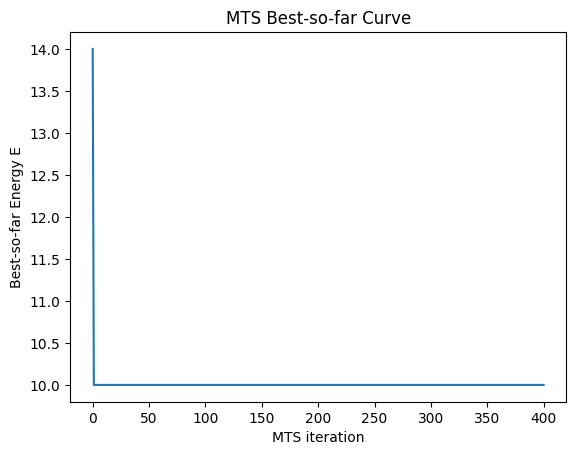

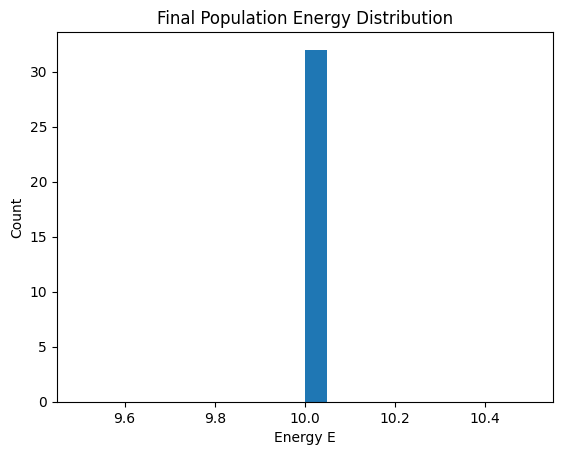

In [16]:
def visualize_mts(res: dict):
    print("Best E:", res["best_E"])
    print("Best bitstring (0/1):", "".join(map(str, res["best_s_01"].tolist())))
    print("Elapsed (s):", f"{res['elapsed_sec']:.3f}")

    trace = res["best_trace"]
    popE = res["population_E"]

    plt.figure()
    plt.plot(trace)
    plt.xlabel("MTS iteration")
    plt.ylabel("Best-so-far Energy E")
    plt.title("MTS Best-so-far Curve")
    plt.show()

    plt.figure()
    plt.hist(popE, bins=20)
    plt.xlabel("Energy E")
    plt.ylabel("Count")
    plt.title("Final Population Energy Distribution")
    plt.show()
visualize_mts(res)

Best E Found: 10
First reached at iteration: 1


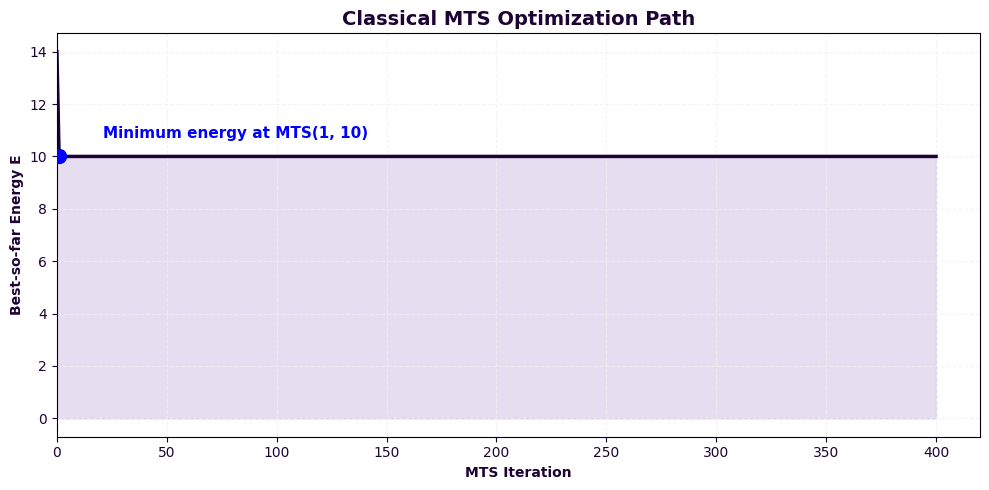

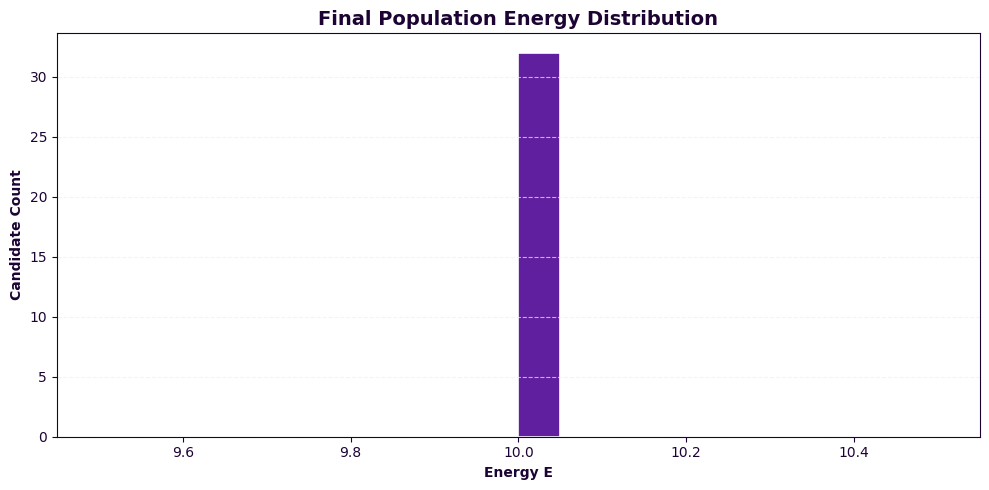

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_classical_mts_results(mts_res):
    """
    Visualizes the optimization path and population distribution 
    with a 'Quantum Vibe' aesthetic.
    """
    # 1. Extraction and Search Logic
    trace = mts_res["best_trace"]
    pop_e = mts_res["population_E"]
    best_e = mts_res["best_E"]

#Dynamically find the first iteration index where the best energy was hit
#Using np.where is faster and cleaner for finding the first occurrence
    iteration_indices = np.where(trace == best_e)[0]
    best_iteration = iteration_indices[0] if iteration_indices.size > 0 else 0

    print(f"Best E Found: {best_e}")
    print(f"First reached at iteration: {best_iteration}")

    bg_color = '#FFFFFF'     # White background
    accent_color = '#1c0333' # Deep dark purple for text/lines
    bar_color = '#601f9e'    # Vibrant purple for fills/bars
    grid_color = '#F0F0F0'   # Light grey for subtle grid

    # --- Plot 1: Best-so-far Curve ---
    fig1, ax1 = plt.subplots(figsize=(10, 5))
    fig1.patch.set_facecolor(bg_color)
    ax1.set_facecolor(bg_color)

    ax1.plot(trace, color=accent_color, linewidth=2.5, label='Energy Path')

#Highlight the minimum energy point
    ax1.scatter(best_iteration, best_e, color='blue', s=100, zorder=5, 
                label=f'Min Energy ({best_iteration}, {best_e})')

#Annotate the minimum point
    ax1.text(best_iteration + (len(trace)*0.05), best_e + (max(trace)*0.05), 
             f'Minimum energy at MTS({best_iteration}, {best_e})', 
             fontsize=11, color='blue', fontweight='bold')

    # Formatting
    ax1.set_xlabel("MTS Iteration", color=accent_color, fontweight='bold')
    ax1.set_ylabel("Best-so-far Energy E", color=accent_color, fontweight='bold')
    ax1.set_title("Classical MTS Optimization Path", color=accent_color, fontsize=14, fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.7, color=grid_color)
    ax1.tick_params(colors=accent_color)
    ax1.set_xlim(left=0) # Ensure X-axis starts at 0
#Modern area fill
    ax1.fill_between(range(len(trace)), trace, color=bar_color, alpha=0.15)

    plt.tight_layout()
    plt.show()

    # --- Plot 2: Final Population Energy Distribution ---
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    fig2.patch.set_facecolor(bg_color)
    ax2.set_facecolor(bg_color)

    # Histogram
    ax2.hist(pop_e, bins=20, color=bar_color, edgecolor=bg_color, linewidth=1.2)

    # Formatting
    ax2.set_xlabel("Energy E", color=accent_color, fontweight='bold')
    ax2.set_ylabel("Candidate Count", color=accent_color, fontweight='bold')
    ax2.set_title("Final Population Energy Distribution", color=accent_color, fontsize=14, fontweight='bold')
    ax2.grid(axis='y', linestyle='--', alpha=0.7, color=grid_color)
    ax2.tick_params(colors=accent_color)

    # Clean up the spines
    for spine in ax2.spines.values():
        spine.set_edgecolor(accent_color)

    plt.tight_layout()
    plt.show()

#Usage:
visualize_classical_mts_results(res)